# F1 Project: Beating the Odds

---
# <font color='yellow'>Data Source, Import Packages</font>

## Import package

In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from matplotlib import pyplot as plt
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, accuracy_score

# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from sklearn.neural_network import MLPClassifier, MLPRegressor

## Read file

In [2]:
# primary dataset
df_races = pd.read_csv('./data/races.csv')
df_results = pd.read_csv('./data/results copy.csv')
df_qualifying = pd.read_csv('./data/qualifying_update.csv')
df_driver_standings = pd.read_csv('./data/driver_standings.csv')
df_constructor_standings = pd.read_csv('./data/constructor_standings.csv')

In [3]:
# secondary dataset
df_constructor_results = pd.read_csv('./data/constructor_results.csv')
df_pit_stops = pd.read_csv('./data/pit_stops.csv')
df_lap_times = pd.read_csv('./data/lap_times.csv')

In [4]:
# lookup dataset
df_constructors = pd.read_csv('./data/constructors.csv')
df_drivers = pd.read_csv('./data/drivers.csv')
df_status = pd.read_csv('./data/status.csv')
df_circuits = pd.read_csv('./data/circuits.csv')

---
# <font color='yellow'> Wrangling, Cleaning, Exploring</font>

## MERGING

In [5]:
# RACES
# merge, drop
merge_races = pd.merge(df_races, df_circuits, 
                       how='inner', 
                       on=['circuitId'])

races = merge_races.drop(columns = ['name_x', 'time', 'date', 'url_x', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'name_y', 'url_y'])

# sort, reindex, reset index
races.sort_values(['year', 'round'], ascending = True, inplace = True)
races = races.reindex(columns = ['year', 'round', 'circuitRef', 'location', 'country', 'lat', 'lng', 'alt', 'raceId'])
races.reset_index(drop = True, inplace = True)

In [6]:
# RESULTS
# merge, drop
merge_results = pd.merge(df_results, races,
                   how='inner', 
                   on=['raceId'])

drop_results = merge_results.drop(columns = ['positionText', 'position', 'number', 'location', 'country', 'lat', 'lng', 'alt',
                                       'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed'])

merge_results2 = pd.merge(drop_results, df_status,
                   how='inner', 
                   on=['statusId'])

merge_results3 = pd.merge(merge_results2, df_constructors[['constructorId', 'constructorRef']],
                   how='inner', 
                   on=['constructorId'])

results = pd.merge(merge_results3, df_drivers[['driverId', 'driverRef','dob','nationality']],
                   how='inner', 
                   on=['driverId'])

# sort, reindex, reset index
results.sort_values(['year', 'round', 'positionOrder'], ascending = True, inplace = True)
results = results.reindex(columns = ['year', 'round', 'circuitRef', 'constructorRef', 'driverRef','dob', 'nationality', 
                                     'grid', 'positionOrder', 'points', 'status', 'laps', 'time', 'milliseconds', 'resultId', 
                                     'raceId', 'circuitId', 'constructorId', 'driverId', 'statusId'])
results.reset_index(drop = True, inplace = True)

In [7]:
# QUALIFYING (partly manipulated in excel)
# merge, drop
merge_qualifying = pd.merge(df_qualifying, 
                            df_drivers[['driverId', 'driverRef']],
                   how='left', 
                   on=['driverId'])

merge_qualifying2 = pd.merge(merge_qualifying, 
                            df_constructors[['constructorId', 'constructorRef']],
                   how='left', 
                   on=['constructorId'])

merge_qualifying3 = pd.merge(merge_qualifying2, 
                            races[['raceId', 'year', 'round', 'circuitRef']],
                   how='left', 
                   on=['raceId'])

qualifying = merge_qualifying3.drop(columns = ['qualifyId', 'number', 'q1', 'q2', 'q3'])

# sort, reindex, reset index
qualifying.sort_values(['year', 'round', 'position'], ascending = True, inplace = True)
qualifying = qualifying.reindex(columns = ['year', 'round', 'circuitRef', 'constructorRef', 'driverRef','q', 'position', 
                                           'raceId', 'driverId', 'constructorId'])
qualifying.reset_index(drop = True, inplace = True)

In [8]:
# DRIVER STANDINGS
# merge, drop
merge_driver_standings = pd.merge(df_driver_standings, 
                            df_drivers[['driverId', 'driverRef']],
                   how='left', 
                   on=['driverId'])

merge_driver_standings2 = pd.merge(merge_driver_standings, 
                            races[['raceId', 'year', 'round', 'circuitRef']],
                   how='left', 
                   on=['raceId'])

merge_driver_standings3 = pd.merge(merge_driver_standings2, 
                            results[['raceId', 'driverId', 'constructorRef']],
                   how='left', 
                   on=['raceId', 'driverId'])

driver_standings = merge_driver_standings3.drop(columns = ['positionText', 'driverStandingsId'])

# sort, reindex, reset index
driver_standings.sort_values(['year', 'round', 'position'], ascending = True, inplace = True)
driver_standings = driver_standings.reindex(columns = ['year', 'round', 'circuitRef', 'driverRef', 'position', 'wins', 'points',  
                                           'raceId', 'driverId'])
driver_standings.reset_index(drop = True, inplace = True)

In [9]:
# CONSTRUCTOR STANDINGS
# merge, drop
merge_constructor_standings = pd.merge(df_constructor_standings, 
                            df_constructors[['constructorId', 'constructorRef']],
                   how='left', 
                   on=['constructorId'])

merge_constructor_standings2 = pd.merge(merge_constructor_standings, 
                            races[['raceId', 'year', 'round', 'circuitRef']],
                   how='left', 
                   on=['raceId'])

constructor_standings = merge_constructor_standings2.drop(columns = ['positionText', 'constructorStandingsId'])

# sort, reindex, reset index
constructor_standings.sort_values(['year', 'round', 'position'], ascending = True, inplace = True)
constructor_standings = constructor_standings.reindex(columns = ['year', 'round', 'circuitRef', 'constructorRef', 'position', 'wins', 'points',  
                                           'raceId', 'constructorId'])
constructor_standings.reset_index(drop = True, inplace = True)

In [10]:
# PIT STOPS
# merge, drop
merge_pit_stops = pd.merge(df_pit_stops, 
                            df_drivers[['driverId', 'driverRef']],
                   how='left', 
                   on=['driverId'])

merge_pit_stops2 = pd.merge(merge_pit_stops, 
                            races[['raceId', 'year', 'round', 'circuitRef']],
                   how='left', 
                   on=['raceId'])

pit_stops = pd.merge(merge_pit_stops2, 
                            results[['raceId', 'driverId', 'constructorRef']],
                   how='left', 
                   on=['raceId', 'driverId'])

pit_stops = pit_stops.drop(columns = ['time'])

# # sort, reindex, reset index
pit_stops.sort_values(['year', 'round'], ascending = True, inplace = True)
pit_stops = pit_stops.reindex(columns = ['year', 'round', 'circuitRef', 'constructorRef', 'driverRef', 'stop', 'lap', 'duration', 'milliseconds', 
                                           'raceId', 'driverId'])
pit_stops.reset_index(drop = True, inplace = True)

In [11]:
# CONSTRUCTOR RESULTS
# merge, drop
merge_constructor_results = pd.merge(df_constructor_results, 
                            df_constructors[['constructorId', 'constructorRef']],
                   how='left', 
                   on=['constructorId'])

merge_constructor_results2 = pd.merge(merge_constructor_results, 
                            races[['raceId', 'year', 'round', 'circuitRef']],
                   how='left', 
                   on=['raceId'])

merge_constructor_results2

constructor_results = merge_constructor_results2.drop(columns = ['constructorResultsId'])
constructor_results

# sort, reindex, reset index
constructor_results.sort_values(['year', 'round', 'points'], ascending = True, inplace = True)
constructor_results = constructor_results.reindex(columns = ['year', 'round', 'circuitRef', 'constructorRef', 'points', 'status', 
                                           'raceId', 'constructorId'])
constructor_results.reset_index(drop = True, inplace = True)

## MODELING DATAFRAME

In [12]:
# temporarily rename 
subset = results.copy()

# merge additional columns on constructors, drivers and qualifying
    # add: conspoints, conswins, consposition
merge_subset = pd.merge(subset, 
                            constructor_standings[['raceId', 'constructorId', 'position', 'wins', 'points']],
                   how='left', 
                   on=['raceId', 'constructorId'])

merge_subset.rename(columns = {'points_x': 'race_pts',
                        'position': 'cnstr_pos',
                        'wins': 'cnstr_wins',
                        'points_y': 'cnstr_pts'}, inplace = True)

    # add: driverpoints, driverwins, driverposition
merge_subset2 = pd.merge(merge_subset, 
                        driver_standings[['raceId', 'driverId', 'position', 'wins', 'points']],
               how='left', 
               on=['raceId', 'driverId'])  

merge_subset2.rename(columns = {'position': 'driver_pos',
                        'wins': 'driver_wins',
                        'points': 'driver_pts'}, inplace = True)    

# convert dob, q to datetime
merge_subset2['dob'] = pd.to_datetime(merge_subset2['dob'])

    # extract year feature
merge_subset2['dob_year'] = merge_subset2['dob'].dt.year

    # calculate age of driver vis-a-vis race year
merge_subset2['age'] = merge_subset2.year - merge_subset2.dob_year



# drop unnecessary columns
subset = merge_subset2.drop(columns = ['status', 'laps', 'time', 'resultId', 'raceId', 'circuitId', 'constructorId', 
                                'driverId', 'statusId', 'dob', 'dob_year', 'milliseconds'])
subset.rename(columns = {'points_x': 'driver_pts',
                        'position': 'cnstr_pos',
                        'wins': 'cnstr_wins',
                        'points_y': 'cnstr_pts'}, inplace = True)
subset.sort_values(by = ['year', 'round', 'positionOrder'], ascending = True, inplace = True)
subset.reset_index(drop = True, inplace = True)
subset

,year,round,circuitRef,constructorRef,driverRef,nationality,grid,positionOrder,race_pts,cnstr_pos,cnstr_wins,cnstr_pts,driver_pos,driver_wins,driver_pts,age
0,1950,1,silverstone,alfa,farina,Italian,1,1,9.0,NaN,NaN,NaN,1.0,1.0,9.0,44
1,1950,1,silverstone,alfa,fagioli,Italian,2,2,6.0,NaN,NaN,NaN,2.0,0.0,6.0,52
2,1950,1,silverstone,alfa,reg_parnell,British,4,3,4.0,NaN,NaN,NaN,3.0,0.0,4.0,39
3,1950,1,silverstone,lago,cabantous,French,6,4,3.0,NaN,NaN,NaN,4.0,0.0,3.0,46
4,1950,1,silverstone,lago,rosier,French,9,5,2.0,NaN,NaN,NaN,5.0,0.0,2.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26029,2022,22,yas_marina,williams,latifi,Canadian,20,16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,27
26030,2022,22,yas_marina,alphatauri,tsunoda,Japanese,11,17,0.0,NaN,NaN,NaN,NaN,NaN,NaN,22
26031,2022,22,yas_marina,mclaren,norris,British,7,18,6.0,NaN,NaN,NaN,NaN,NaN,NaN,23
26032,2022,22,yas_marina,haas,kevin_magnussen,Danish,16,19,0.0,NaN,NaN,NaN,NaN,NaN,NaN,30


## DATA IMPUTATION

#### Method 1

In [13]:
# missing_col = ['cnstr_pos']
# for i in missing_col:
#     subset.loc[subset.loc[:,i].isnull(),i]=subset.loc[:,i].mean()
    
    
# missing_col = ['cnstr_wins']
# for i in missing_col:
#     subset.loc[subset.loc[:,i].isnull(),i]=subset.loc[:,i].mean()
    
    
# missing_col = ['cnstr_pts']
# for i in missing_col:
#     subset.loc[subset.loc[:,i].isnull(),i]=subset.loc[:,i].mean()
    
    
# # export as csv
# subset.to_csv('testdata.csv')
# subset.head()

#### Method 2

In [14]:
# missing_col = ['cnstr_pos', 'cnstr_wins', 'cnstr_pts']
# for i in missing_col:
#     subset.loc[subset.loc[:,i].isnull(),i]=subset.loc[:,i].mean()

#### Method 3

In [15]:
subset.loc[subset.loc[:,'cnstr_pos'].isnull(),'cnstr_pos']=subset.loc[:,'cnstr_pos'].mean()
subset.loc[subset.loc[:,'cnstr_wins'].isnull(),'cnstr_wins']=subset.loc[:,'cnstr_wins'].mean()
subset.loc[subset.loc[:,'cnstr_pts'].isnull(),'cnstr_pts']=subset.loc[:,'cnstr_pts'].mean()
subset

,year,round,circuitRef,constructorRef,driverRef,nationality,grid,positionOrder,race_pts,cnstr_pos,cnstr_wins,cnstr_pts,driver_pos,driver_wins,driver_pts,age
0,1950,1,silverstone,alfa,farina,Italian,1,1,9.0,6.49349,0.77627,36.095275,1.0,1.0,9.0,44
1,1950,1,silverstone,alfa,fagioli,Italian,2,2,6.0,6.49349,0.77627,36.095275,2.0,0.0,6.0,52
2,1950,1,silverstone,alfa,reg_parnell,British,4,3,4.0,6.49349,0.77627,36.095275,3.0,0.0,4.0,39
3,1950,1,silverstone,lago,cabantous,French,6,4,3.0,6.49349,0.77627,36.095275,4.0,0.0,3.0,46
4,1950,1,silverstone,lago,rosier,French,9,5,2.0,6.49349,0.77627,36.095275,5.0,0.0,2.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26029,2022,22,yas_marina,williams,latifi,Canadian,20,16,0.0,6.49349,0.77627,36.095275,NaN,NaN,NaN,27
26030,2022,22,yas_marina,alphatauri,tsunoda,Japanese,11,17,0.0,6.49349,0.77627,36.095275,NaN,NaN,NaN,22
26031,2022,22,yas_marina,mclaren,norris,British,7,18,6.0,6.49349,0.77627,36.095275,NaN,NaN,NaN,23
26032,2022,22,yas_marina,haas,kevin_magnussen,Danish,16,19,0.0,6.49349,0.77627,36.095275,NaN,NaN,NaN,30


## DUMMY CONVERSION

In [16]:
# get dummies
dfmodel_dummies = pd.get_dummies(subset, columns = ['circuitRef', 'constructorRef', 'nationality'])
dfmodel = dfmodel_dummies.copy()
dfmodel.to_csv('testdata.csv')


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
dfmodel.tail()

,year,round,driverRef,grid,positionOrder,race_pts,cnstr_pos,cnstr_wins,cnstr_pts,driver_pos,driver_wins,driver_pts,age,circuitRef_adelaide,circuitRef_ain-diab,circuitRef_aintree,circuitRef_albert_park,circuitRef_americas,circuitRef_anderstorp,circuitRef_avus,circuitRef_bahrain,circuitRef_baku,circuitRef_boavista,circuitRef_brands_hatch,circuitRef_bremgarten,circuitRef_buddh,circuitRef_catalunya,circuitRef_charade,circuitRef_dallas,circuitRef_detroit,circuitRef_dijon,circuitRef_donington,circuitRef_essarts,circuitRef_estoril,circuitRef_fuji,circuitRef_galvez,circuitRef_george,circuitRef_hockenheimring,circuitRef_hungaroring,circuitRef_imola,circuitRef_indianapolis,circuitRef_interlagos,circuitRef_istanbul,circuitRef_jacarepagua,circuitRef_jarama,circuitRef_jeddah,circuitRef_jerez,circuitRef_kyalami,circuitRef_las_vegas,circuitRef_lemans,circuitRef_long_beach,circuitRef_losail,circuitRef_magny_cours,circuitRef_marina_bay,circuitRef_miami,circuitRef_monaco,circuitRef_monsanto,circuitRef_montjuic,circuitRef_monza,circuitRef_mosport,circuitRef_mugello,circuitRef_nivelles,circuitRef_nurburgring,circuitRef_okayama,circuitRef_pedralbes,circuitRef_pescara,circuitRef_phoenix,circuitRef_portimao,circuitRef_red_bull_ring,circuitRef_reims,circuitRef_ricard,circuitRef_riverside,circuitRef_rodriguez,circuitRef_sebring,circuitRef_sepang,circuitRef_shanghai,circuitRef_silverstone,circuitRef_sochi,circuitRef_spa,circuitRef_suzuka,circuitRef_tremblant,circuitRef_valencia,circuitRef_villeneuve,circuitRef_watkins_glen,circuitRef_yas_marina,circuitRef_yeongam,circuitRef_zandvoort,circuitRef_zeltweg,circuitRef_zolder,constructorRef_adams,constructorRef_afm,constructorRef_ags,constructorRef_alfa,constructorRef_alphatauri,constructorRef_alpine,constructorRef_alta,constructorRef_amon,constructorRef_apollon,constructorRef_arrows,constructorRef_arzani-volpini,constructorRef_aston_martin,constructorRef_ats,constructorRef_bar,constructorRef_behra-porsche,constructorRef_bellasi,constructorRef_benetton,constructorRef_bmw,constructorRef_bmw_sauber,constructorRef_boro,constructorRef_brabham,constructorRef_brabham-alfa_romeo,constructorRef_brabham-brm,constructorRef_brabham-climax,constructorRef_brabham-ford,constructorRef_brabham-repco,constructorRef_brawn,constructorRef_brm,constructorRef_brm-ford,constructorRef_bromme,constructorRef_brp,constructorRef_bugatti,constructorRef_butterworth,constructorRef_caterham,constructorRef_cisitalia,constructorRef_coloni,constructorRef_connaught,constructorRef_connew,constructorRef_cooper,constructorRef_cooper-alfa_romeo,constructorRef_cooper-ats,constructorRef_cooper-borgward,constructorRef_cooper-brm,constructorRef_cooper-castellotti,constructorRef_cooper-climax,constructorRef_cooper-ferrari,constructorRef_cooper-ford,constructorRef_cooper-maserati,constructorRef_cooper-osca,constructorRef_dallara,constructorRef_de_tomaso-alfa_romeo,constructorRef_de_tomaso-ferrari,constructorRef_de_tomaso-osca,constructorRef_deidt,constructorRef_del_roy,constructorRef_derrington,constructorRef_dunn,constructorRef_eagle-climax,constructorRef_eagle-weslake,constructorRef_elder,constructorRef_emeryson,constructorRef_emw,constructorRef_enb,constructorRef_ensign,constructorRef_epperly,constructorRef_era,constructorRef_eurobrun,constructorRef_ewing,constructorRef_ferguson,constructorRef_ferrari,constructorRef_fittipaldi,constructorRef_fondmetal,constructorRef_footwork,constructorRef_force_india,constructorRef_forti,constructorRef_frazer_nash,constructorRef_fry,constructorRef_gilby,constructorRef_gordini,constructorRef_haas,constructorRef_hall,constructorRef_hesketh,constructorRef_hill,constructorRef_honda,constructorRef_hrt,constructorRef_hwm,constructorRef_iso_marlboro,constructorRef_jaguar,constructorRef_jbw,constructorRef_jordan,constructorRef_kauhsen,constructorRef_klenk,constructorRef_kojima,constructorRef_kurtis_kraft,constructorRef_kuzma,constructorRef_lago,constructorRef_lambo,constructorRef_lancia,constructorRef_langley,constructorRef

---
# <font color='yellow'>Regression</font>

## TEST-TRAIN SPLIT

In [17]:
# # dropping any NaNs
# dfmodel.dropna(axis = 0, how = 'any', inplace = True)

In [18]:
# Regression
df = dfmodel[(dfmodel.year >= 2015)] # 2015 is the median of the debut years of 2021 active racers
year_train_test = 2021

train = df[df.year < year_train_test] # data timeframe to train
X_train = train.drop(['driverRef', 'positionOrder', 'driver_wins', 'driver_pts','driver_pos','race_pts'], axis = 1) # dropping columns which identify winners
y_train = train['positionOrder'] # data column to train

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

## LOGISTIC REGRESSION

In [19]:
# Modeling using sklearn
model = LogisticRegression(max_iter=10000, class_weight = 'balanced', C = 0.3) # increasing iterations find the minimal loss
model.fit(X_train, y_train)
    # Suppose we consider a binary classification where the majority target class has 10000 rows, and the minority target class has only 100 rows. In that case, the ratio is 100:1, i.e., for every 100 majority class, there is only one minority class present. This problem is what we refer to as class imbalance

LogisticRegression(C=0.3, class_weight='balanced', max_iter=10000)

In [20]:
score = 0
pred_score = 0
prediction_summary = []
test_summary = []


for round_num in df[df['year'] == year_train_test]['round'].unique():

    test = df[(df['year'] == year_train_test) & (df['round'] == round_num)]
    X_test = test.drop(columns = ['driverRef', 'positionOrder', 'driver_wins', 'driver_pts','driver_pos','race_pts'])
    y_test = test['positionOrder']

    
    #scaling
    X_test_trans = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

    
    # make predictions: podium finish
    y_test_pred = pd.DataFrame(model.predict(X_test_trans), columns = ['prob'])
    
    
    # put y_test predictions in a dataframe
    y_test_pred['round'] = round_num
    y_test_pred['positionOrder'] = y_test.reset_index(drop = True) 
    y_test_pred['act'] = y_test_pred['positionOrder'].apply(lambda x: 1 if x>=1 and x<=3 else 0)
    y_test_pred.sort_values('prob', ascending = True, inplace = True)
    y_test_pred.reset_index(inplace = True, drop = True)
    y_test_pred['pred'] = y_test_pred.index
    y_test_pred['pred'] = np.where((y_test_pred['act']==1) & ((y_test_pred['pred'].index>=0)&(y_test_pred['pred'].index<=2)), 1, 0)
    y_test_pred['positionOrder_pred'] = y_test_pred.index+1
    prediction_summary.append(y_test_pred)
    test_summary.append(test)

 
    # count correct predictions
    pred_score += y_test_pred['pred'].sum()
    score += accuracy_score(y_test, y_test_pred['positionOrder_pred'])

---
# <font color='yellow'>Results</font>

## PREDICTION RESULTS TABLE

In [21]:
# show all prediction/test results in one table for ease of comparison
df_prediction_summary = pd.concat(prediction_summary)
df_test_summary = pd.concat(test_summary) #(driverRef are the names for the actual results)


# merge prediction and actual (test) 
prediction_results = pd.merge(df_prediction_summary,
                              df_test_summary[['round','positionOrder','driverRef']],
                              how = 'left',
                              on = ['round', 'positionOrder']) # driverRef is arranged according to predicted position

## SCORES AND MATRIX

#### How many times did the model correctly predict the position order for all drivers?

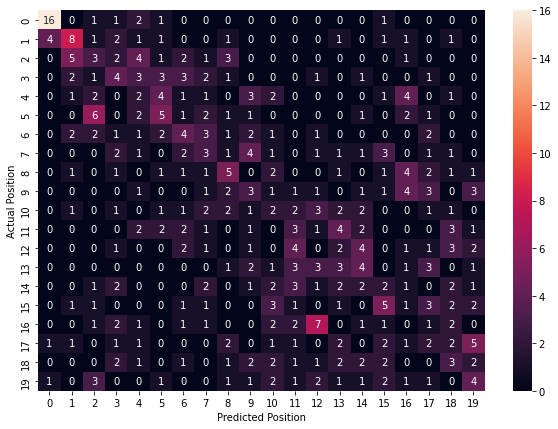

In [22]:
# How many times did the model correctly predict the position order for all drivers 
plt.figure(figsize=(10,7))
cm = confusion_matrix(prediction_results['positionOrder'], prediction_results['positionOrder_pred'])

# export cm2 to csv
export = pd.DataFrame(np.array(cm))
# export.to_csv('confusion_matrix.csv')

sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual Position')
plt.xlabel('Predicted Position');

In [23]:
# accuracy score - all drivers
accuracy_score(prediction_results['positionOrder'], prediction_results['positionOrder_pred'])

0.175

#### How many times did the model correctly predict the position order for rhe top 3 drivers?

In [24]:
# How many times did the model correctly predict the position order for the top 3 drivers
listing = []
for round_num in range(1,max(df_prediction_summary['round'])):
    listing.append(df_prediction_summary[df_prediction_summary['round'] == round_num][0:3])
list_temp = pd.concat(listing)

In [25]:
# accuracy score - top 3 drivers
accuracy_score(list_temp['positionOrder'], list_temp['positionOrder_pred'])

0.3968253968253968

#### How many times did the model correctly predict the top 3 drivers according to odds?

In [26]:
# success metric on odds -  # of races, 3 podium places
race_total = (df[df['year'] == year_train_test]['round'].unique().max())*3
model_score = pred_score / race_total

print("top 3 predicted: ", pred_score, "/",race_total)
print("percent: ", "{0:.2f}%".format(model_score * 100))

top 3 predicted:  38 / 66
percent:  57.58%


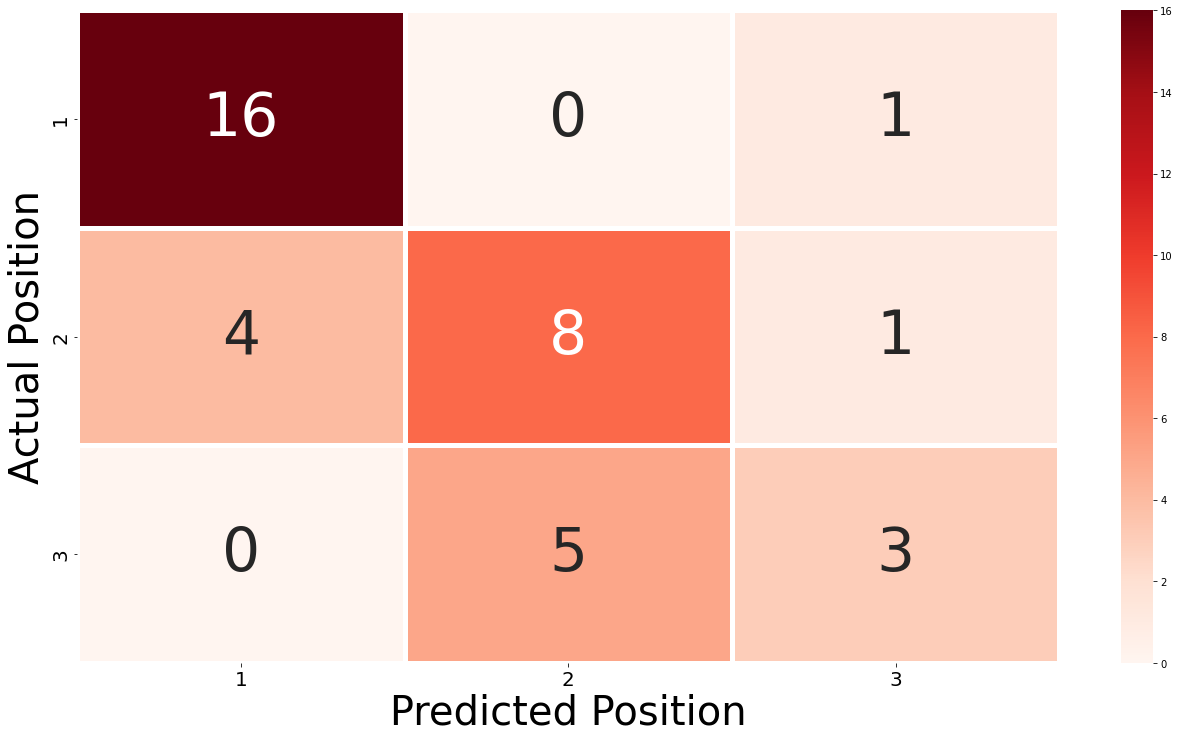

In [27]:
top_3_array = ([[16,0,1],
               [4,8,1],
               [0,5,3]])

plt.figure(figsize=(22,12))
ax = sns.heatmap(pd.DataFrame(np.array(top_3_array), index = [1,2,3], columns = [1,2,3]), 
            annot=True, annot_kws={"size": 60}, fmt='d', linewidths=5, cmap = 'Reds')
plt.ylabel('Actual Position', fontsize=40)
plt.xlabel('Predicted Position', fontsize=40)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
# ax.xaxis.tick_top();

#### How far off is the prediction based on exactly hitting position order?

In [28]:
# how far off is the prediction?
# +: overpredicted, -: underpredicted
prediction_results['positiondiff'] = prediction_results['positionOrder'] - prediction_results['positionOrder_pred']
prediction_results_err = prediction_results.groupby(['positionOrder'])['positiondiff'].mean().to_frame().reset_index()
# prediction_results_err.to_csv('prediction_results_err.csv')
prediction_results_err.head()

,positionOrder,positiondiff
0,1,-1.500000
1,2,-3.318182
2,3,-2.409091
3,4,-2.727273
4,5,-4.636364


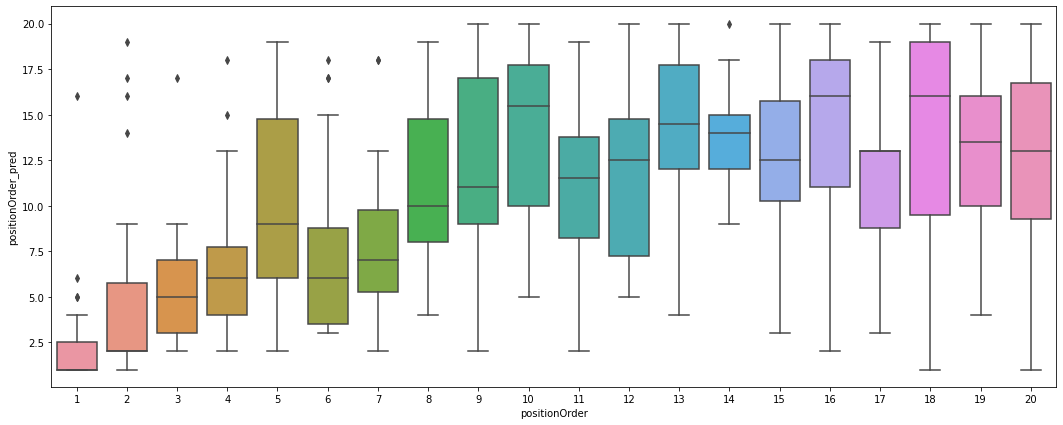

In [29]:
# how far off is the prediction?
plt.figure(figsize=(18,7))
ax = sns.boxplot(data = prediction_results, x = 'positionOrder', y = 'positionOrder_pred');

## BEATING THE ODDS

In [30]:
# read odds file
df_odds = pd.read_excel('./data/odds.xlsx')


# merge prediction results table with odds table
odds_results = pd.merge(prediction_results,
                              df_odds[df_odds['year']==year_train_test][['year','round','circuit','driverRef','odds']],
                              how = 'left',
                              on = ['round', 'driverRef'])

In [31]:
# calculate spending, winning
odds_results['wins'] = np.where((odds_results['pred']==1), odds_results['odds'], 0) # mark wins if the pred column (the prediction) is correctly predicted

spend_amt = 100 # set a fictiuous amount of bet
odds_results['spend'] = spend_amt

odds_results['winnings'] = odds_results['wins'] * odds_results['spend'] # calculate winnings based on spend and correctly predicted podium finishers
odds_results.to_csv('odds_results.csv')
odds_results.head()

,prob,round,positionOrder,act,pred,positionOrder_pred,driverRef,positiondiff,year,circuit,odds,wins,spend,winnings
0,1,1,1,1,1,1,hamilton,0,2021.0,Bahrain Grand Prix,1.3,1.3,100,130.0
1,1,1,2,1,1,2,max_verstappen,0,2021.0,Bahrain Grand Prix,1.3,1.3,100,130.0
2,1,1,5,0,0,3,perez,2,2021.0,Bahrain Grand Prix,2.0,0.0,100,0.0
3,1,1,17,0,0,4,gasly,13,2021.0,Bahrain Grand Prix,10.0,0.0,100,0.0
4,2,1,3,1,0,5,bottas,-2,2021.0,Bahrain Grand Prix,1.7,0.0,100,0.0


In [32]:
# calculate gain/loss
spent = odds_results['spend'].sum() - odds_results['round'].nunique() * spend_amt *17 # subtract 17 x spend_amt since the 'spend' column bets on all 20 instead of only the podium finishers
won = round(odds_results['winnings'].sum(), 2)
gain_loss = round(won-spent, 2)
gain_loss_per = "{0:.2f}%".format((gain_loss / spent) * 100)

print("Total amount spent: ", spent)
print("Total amount won: ", won)
print("Gain/Loss: ", gain_loss)
print("Gain/Loss %: ", gain_loss_per)

Total amount spent:  6600
Total amount won:  8894.0
Gain/Loss:  2294.0
Gain/Loss %:  34.76%


## FEATURE IMPORTANCE
https://betterdatascience.com/feature-importance-python/

In [33]:
df_coef = pd.DataFrame(model.coef_).transpose()
df_coef['avg'] = df_coef.mean(axis=1)

In [34]:
importances = pd.DataFrame(data={
    'Feature': X_train.columns,
    'Importance': abs(df_coef[0])
})
importances = importances.sort_values(by='Importance', ascending=False)
importances.to_csv('importances.csv')

''

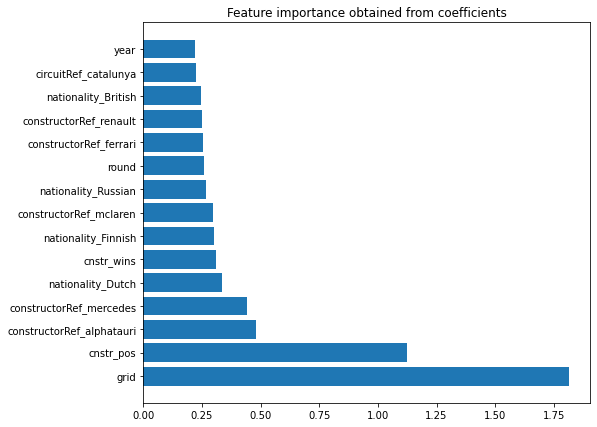

In [35]:
plt.figure(figsize=(8,7))
plt.barh(y=importances['Feature'][0:15], width=importances['Importance'][0:15])
plt.title('Feature importance obtained from coefficients')
;
# plt.xticks(rotation='45');

---
# <font color='yellow'>EXTRA: App input</font>
- Best used when information is complete and accurate i.e. using it after qualifying so that you have the grid position input
- Train data is trimmed to almost to only 2021, where at least 90% of the 2022 drivers are present in 2021
- Idea of the predictor: base predictions based on the current season's results and input previous data immediately

#### Preview of column headers

In [36]:
X_test[0:1]

,year,round,grid,cnstr_pos,cnstr_wins,cnstr_pts,age,circuitRef_adelaide,circuitRef_ain-diab,circuitRef_aintree,circuitRef_albert_park,circuitRef_americas,circuitRef_anderstorp,circuitRef_avus,circuitRef_bahrain,circuitRef_baku,circuitRef_boavista,circuitRef_brands_hatch,circuitRef_bremgarten,circuitRef_buddh,circuitRef_catalunya,circuitRef_charade,circuitRef_dallas,circuitRef_detroit,circuitRef_dijon,circuitRef_donington,circuitRef_essarts,circuitRef_estoril,circuitRef_fuji,circuitRef_galvez,circuitRef_george,circuitRef_hockenheimring,circuitRef_hungaroring,circuitRef_imola,circuitRef_indianapolis,circuitRef_interlagos,circuitRef_istanbul,circuitRef_jacarepagua,circuitRef_jarama,circuitRef_jeddah,circuitRef_jerez,circuitRef_kyalami,circuitRef_las_vegas,circuitRef_lemans,circuitRef_long_beach,circuitRef_losail,circuitRef_magny_cours,circuitRef_marina_bay,circuitRef_miami,circuitRef_monaco,circuitRef_monsanto,circuitRef_montjuic,circuitRef_monza,circuitRef_mosport,circuitRef_mugello,circuitRef_nivelles,circuitRef_nurburgring,circuitRef_okayama,circuitRef_pedralbes,circuitRef_pescara,circuitRef_phoenix,circuitRef_portimao,circuitRef_red_bull_ring,circuitRef_reims,circuitRef_ricard,circuitRef_riverside,circuitRef_rodriguez,circuitRef_sebring,circuitRef_sepang,circuitRef_shanghai,circuitRef_silverstone,circuitRef_sochi,circuitRef_spa,circuitRef_suzuka,circuitRef_tremblant,circuitRef_valencia,circuitRef_villeneuve,circuitRef_watkins_glen,circuitRef_yas_marina,circuitRef_yeongam,circuitRef_zandvoort,circuitRef_zeltweg,circuitRef_zolder,constructorRef_adams,constructorRef_afm,constructorRef_ags,constructorRef_alfa,constructorRef_alphatauri,constructorRef_alpine,constructorRef_alta,constructorRef_amon,constructorRef_apollon,constructorRef_arrows,constructorRef_arzani-volpini,constructorRef_aston_martin,constructorRef_ats,constructorRef_bar,constructorRef_behra-porsche,constructorRef_bellasi,constructorRef_benetton,constructorRef_bmw,constructorRef_bmw_sauber,constructorRef_boro,constructorRef_brabham,constructorRef_brabham-alfa_romeo,constructorRef_brabham-brm,constructorRef_brabham-climax,constructorRef_brabham-ford,constructorRef_brabham-repco,constructorRef_brawn,constructorRef_brm,constructorRef_brm-ford,constructorRef_bromme,constructorRef_brp,constructorRef_bugatti,constructorRef_butterworth,constructorRef_caterham,constructorRef_cisitalia,constructorRef_coloni,constructorRef_connaught,constructorRef_connew,constructorRef_cooper,constructorRef_cooper-alfa_romeo,constructorRef_cooper-ats,constructorRef_cooper-borgward,constructorRef_cooper-brm,constructorRef_cooper-castellotti,constructorRef_cooper-climax,constructorRef_cooper-ferrari,constructorRef_cooper-ford,constructorRef_cooper-maserati,constructorRef_cooper-osca,constructorRef_dallara,constructorRef_de_tomaso-alfa_romeo,constructorRef_de_tomaso-ferrari,constructorRef_de_tomaso-osca,constructorRef_deidt,constructorRef_del_roy,constructorRef_derrington,constructorRef_dunn,constructorRef_eagle-climax,constructorRef_eagle-weslake,constructorRef_elder,constructorRef_emeryson,constructorRef_emw,constructorRef_enb,constructorRef_ensign,constructorRef_epperly,constructorRef_era,constructorRef_eurobrun,constructorRef_ewing,constructorRef_ferguson,constructorRef_ferrari,constructorRef_fittipaldi,constructorRef_fondmetal,constructorRef_footwork,constructorRef_force_india,constructorRef_forti,constructorRef_frazer_nash,constructorRef_fry,constructorRef_gilby,constructorRef_gordini,constructorRef_haas,constructorRef_hall,constructorRef_hesketh,constructorRef_hill,constructorRef_honda,constructorRef_hrt,constructorRef_hwm,constructorRef_iso_marlboro,constructorRef_jaguar,constructorRef_jbw,constructorRef_jordan,constructorRef_kauhsen,constructorRef_klenk,constructorRef_kojima,constructorRef_kurtis_kraft,constructorRef_kuzma,constructorRef_lago,constructorRef_lambo,constructorRef_lancia,constructorRef_langley,constructorRef_larrousse,constructorRef_lds,constructorRef_lds-alfa_romeo,constru

In [37]:
X_test.columns

Index(['year', 'round', 'grid', 'cnstr_pos', 'cnstr_wins', 'cnstr_pts', 'age',
       'circuitRef_adelaide', 'circuitRef_ain-diab', 'circuitRef_aintree',
       ...
       'nationality_Portuguese', 'nationality_Rhodesian',
       'nationality_Russian', 'nationality_South African',
       'nationality_Spanish', 'nationality_Swedish', 'nationality_Swiss',
       'nationality_Thai', 'nationality_Uruguayan', 'nationality_Venezuelan'],
      dtype='object', length=335)

In [38]:
subset['circuitRef'].nunique(), subset['constructorRef'].nunique(), subset['nationality'].nunique()

(76, 210, 42)

#### Inputs of 3 sample drivers to predict

In [39]:
# hamilton - year, round, grid, cnstr_pos, cnstr_wins, cnstr_pts, age, spa, mercedes, british
# X_user = [[2022, 14, 7, 3, 0, 314, 37], 
#           [0]*65,[1],[0]*10, 
#           [0]*137,[1], [0]*72, 
#           [0]*8,[1],[0]*33]

# hamilton - year, round, grid, cnstr_pos, cnstr_wins, cnstr_pts, age, zandvoort, mercedes, british
# X_user = [[2022, 15, 4, 3, 0, 314, 37], 
#           [0]*65,[1],[0]*10, 
#           [0]*137,[1], [0]*72, 
#           [0]*8,[1],[0]*33]

# norris - year, round, grid, cnstr_pos, cnstr_wins, cnstr_pts, age, spa, mclaren, british
# X_user = [[2022, 14, 18, 5, 0, 95, 23], 
#           [0]*65,[1],[0]*10, 
#           [0]*132,[1], [0]*77, 
#           [0]*8,[1],[0]*33]


#### Predict the position of example driver

In [40]:
# hamilton - year, round, grid, cnstr_pos, cnstr_wins, cnstr_pts, age, zandvoort, mercedes, british
X_user = [[2022, 15, 4, 3, 0, 314, 37], 
          [0]*65,[1],[0]*10, 
          [0]*137,[1], [0]*72, 
          [0]*8,[1],[0]*33]

In [41]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [42]:
X_user_flatten = flatten(X_user)

In [43]:
X_user_df = pd.DataFrame(X_user_flatten).T

In [44]:
X_user_df.columns = X_test.columns.to_list()

In [45]:
X_user_df

,year,round,grid,cnstr_pos,cnstr_wins,cnstr_pts,age,circuitRef_adelaide,circuitRef_ain-diab,circuitRef_aintree,circuitRef_albert_park,circuitRef_americas,circuitRef_anderstorp,circuitRef_avus,circuitRef_bahrain,circuitRef_baku,circuitRef_boavista,circuitRef_brands_hatch,circuitRef_bremgarten,circuitRef_buddh,circuitRef_catalunya,circuitRef_charade,circuitRef_dallas,circuitRef_detroit,circuitRef_dijon,circuitRef_donington,circuitRef_essarts,circuitRef_estoril,circuitRef_fuji,circuitRef_galvez,circuitRef_george,circuitRef_hockenheimring,circuitRef_hungaroring,circuitRef_imola,circuitRef_indianapolis,circuitRef_interlagos,circuitRef_istanbul,circuitRef_jacarepagua,circuitRef_jarama,circuitRef_jeddah,circuitRef_jerez,circuitRef_kyalami,circuitRef_las_vegas,circuitRef_lemans,circuitRef_long_beach,circuitRef_losail,circuitRef_magny_cours,circuitRef_marina_bay,circuitRef_miami,circuitRef_monaco,circuitRef_monsanto,circuitRef_montjuic,circuitRef_monza,circuitRef_mosport,circuitRef_mugello,circuitRef_nivelles,circuitRef_nurburgring,circuitRef_okayama,circuitRef_pedralbes,circuitRef_pescara,circuitRef_phoenix,circuitRef_portimao,circuitRef_red_bull_ring,circuitRef_reims,circuitRef_ricard,circuitRef_riverside,circuitRef_rodriguez,circuitRef_sebring,circuitRef_sepang,circuitRef_shanghai,circuitRef_silverstone,circuitRef_sochi,circuitRef_spa,circuitRef_suzuka,circuitRef_tremblant,circuitRef_valencia,circuitRef_villeneuve,circuitRef_watkins_glen,circuitRef_yas_marina,circuitRef_yeongam,circuitRef_zandvoort,circuitRef_zeltweg,circuitRef_zolder,constructorRef_adams,constructorRef_afm,constructorRef_ags,constructorRef_alfa,constructorRef_alphatauri,constructorRef_alpine,constructorRef_alta,constructorRef_amon,constructorRef_apollon,constructorRef_arrows,constructorRef_arzani-volpini,constructorRef_aston_martin,constructorRef_ats,constructorRef_bar,constructorRef_behra-porsche,constructorRef_bellasi,constructorRef_benetton,constructorRef_bmw,constructorRef_bmw_sauber,constructorRef_boro,constructorRef_brabham,constructorRef_brabham-alfa_romeo,constructorRef_brabham-brm,constructorRef_brabham-climax,constructorRef_brabham-ford,constructorRef_brabham-repco,constructorRef_brawn,constructorRef_brm,constructorRef_brm-ford,constructorRef_bromme,constructorRef_brp,constructorRef_bugatti,constructorRef_butterworth,constructorRef_caterham,constructorRef_cisitalia,constructorRef_coloni,constructorRef_connaught,constructorRef_connew,constructorRef_cooper,constructorRef_cooper-alfa_romeo,constructorRef_cooper-ats,constructorRef_cooper-borgward,constructorRef_cooper-brm,constructorRef_cooper-castellotti,constructorRef_cooper-climax,constructorRef_cooper-ferrari,constructorRef_cooper-ford,constructorRef_cooper-maserati,constructorRef_cooper-osca,constructorRef_dallara,constructorRef_de_tomaso-alfa_romeo,constructorRef_de_tomaso-ferrari,constructorRef_de_tomaso-osca,constructorRef_deidt,constructorRef_del_roy,constructorRef_derrington,constructorRef_dunn,constructorRef_eagle-climax,constructorRef_eagle-weslake,constructorRef_elder,constructorRef_emeryson,constructorRef_emw,constructorRef_enb,constructorRef_ensign,constructorRef_epperly,constructorRef_era,constructorRef_eurobrun,constructorRef_ewing,constructorRef_ferguson,constructorRef_ferrari,constructorRef_fittipaldi,constructorRef_fondmetal,constructorRef_footwork,constructorRef_force_india,constructorRef_forti,constructorRef_frazer_nash,constructorRef_fry,constructorRef_gilby,constructorRef_gordini,constructorRef_haas,constructorRef_hall,constructorRef_hesketh,constructorRef_hill,constructorRef_honda,constructorRef_hrt,constructorRef_hwm,constructorRef_iso_marlboro,constructorRef_jaguar,constructorRef_jbw,constructorRef_jordan,constructorRef_kauhsen,constructorRef_klenk,constructorRef_kojima,constructorRef_kurtis_kraft,constructorRef_kuzma,constructorRef_lago,constructorRef_lambo,constructorRef_lancia,constructorRef_langley,constructorRef_larrousse,constructorRef_lds,constructorRef_lds-alfa_romeo,constru

In [46]:
# predicted result of the chosen driver
pd.DataFrame(model.predict(X_user_df))

,0
0,19


---
# <font color='yellow'>Notes</font>

exported files:
- confusion_matrix
- prediction_results_err
- odds_results
- importances